In [1]:
import pandas as pd

from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

from datetime import date, timedelta
from pathlib import Path

import numpy as np

In [2]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import math

In [4]:
pd.set_option('display.max_columns', None)

# Банки

Запрос для формирования таблицы по всем отзывам банков за последние 5 лет:

In [5]:
query = '''
	SELECT DISTINCT
		R.ID,
		CAST(R."DATE" AS date) AS "DATE",
		R.USERID,
		ORM."NAME" AS ORGANIZATION_NAME,
		ORM.ALIAS AS ORGANIZATION_ALIAS,
		CASE 
			WHEN R.REVIEWOBJECTTYPEID = 1 THEN 'Banks'
			WHEN R.REVIEWOBJECTTYPEID = 6 THEN 'InsuranceCompany'
			WHEN R.REVIEWOBJECTTYPEID = 10 THEN 'MFI'
			ELSE NULL
		END AS REVIEW_OBJECT_TYPE,
		R.PARENT,
		R.ROOT,
		R.RATING,
		R.RATINGCOUNTED,
		R.COUNTEDRATING,
		CASE 
			WHEN COUNTEDRATING IN (1, 2) THEN 1
			ELSE NULL
		END	AS BAD_REVIEWS,
		CASE 
			WHEN COUNTEDRATING IN (3, 4, 5) THEN 1
			ELSE NULL
		END AS GOOD_REVIEWS,
		R.PROBLEMSOLVED,
		R.PROBLEMSOLUTIONDATE,
		R.ISRECOMMENDEDBYUSER,
		R.MODERATIONREASON,
		R.UTMSOURCE || '|' || R.UTMMEDIUM SOURCE_MEDIUM,
		R.COMMENTSCOUNT,
		R.HASCOMPANYRESPONSE,
		R.MODERATIONREASON
	FROM ODS_BATCH.REVIEWS.REVIEWS R
	LEFT JOIN ODS_BATCH.REVIEWS.ORGANIZATIONREADMODELS ORM
		ON R.REVIEWOBJECTID = ORM.ID
	WHERE R.REVIEWOBJECTTYPEID = 1
	AND "DATE" >= DATEADD(year, -5, CURRENT_DATE())
	AND PARENT IS NULL
	AND RATINGCOUNTED = 1
	AND R.COUNTEDRATING IN (1, 2, 3, 4, 5)
    '''

Подключение к snowflake и вывод таблицы:

In [7]:
rank_data = pd.io.sql.read_sql(query, con = engine)

Приводим дату к формату даты, добавляем сегодняшний день и считаем разницу между сегодняшним днем и днем написания отзыва:

In [8]:
rank_data['date'] = pd.to_datetime(rank_data['date'])

today = pd.to_datetime(date.today())

rank_data['days_to_today'] = today -  rank_data['date']

rank_data['days_to_today'] = rank_data['days_to_today'].dt.days

## Считаем временной коэффициент:

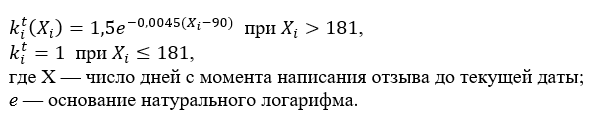

In [9]:
def time_koef(days):
    if days > 181:
        k = 1.5*(math.e**(-0.0045*(days-90)))
    if days <= 181:
        k = 1
    return k

In [10]:
rank_data['time_koef'] = rank_data['days_to_today'].apply(time_koef)

График зависимости временного коэффициента от прошедших дней со дня написания отзыва:

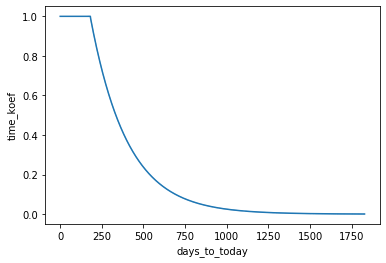

In [11]:
sns.lineplot(x='days_to_today',y='time_koef',data=rank_data);

## Коэффициенты для "проблема решена" и "есть официальный ответ":

In [12]:
def problem_solved_coef(problem_solved):
    if problem_solved == 1:
        coef = 1.7
    else:
        coef = 1
    return coef

In [13]:
rank_data['problem_solved_coef'] = rank_data['problemsolved'].apply(problem_solved_coef)

In [14]:
rank_data['problem_solved_coef'].value_counts()

1.0    8100
1.7    1059
Name: problem_solved_coef, dtype: int64

In [15]:
def company_response_coef(hascompanyresponse):
    if hascompanyresponse == 1:
        coef = 1.2
    else:
        coef = 1
    return coef

In [16]:
rank_data['company_response_coef'] = rank_data['hascompanyresponse'].apply(company_response_coef)

In [17]:
rank_data['company_response_coef'].value_counts()

1.0    5538
1.2    3621
Name: company_response_coef, dtype: int64

## Считаем рейтинг конкретного отзыва

### Рейтинг отзыва = 
        Проверенная оценка от пользователя * 
        Коэффициент "Проблема решена" *
        Коэффициент "Есть оф ответ" * 
        Временной коэффициент

In [18]:
rank_data['final_rating'] = (rank_data['countedrating'] * rank_data['problem_solved_coef'] * rank_data['company_response_coef']
                        * rank_data['time_koef'])

## Группируем данные по банкам для расчета рейтинга банка:

In [21]:
banks_data = (rank_data.groupby('organization_name')
            .agg({'final_rating':'sum','time_koef':'sum','id':'count','problemsolved':'sum'
                  ,'hascompanyresponse':'sum','rating':'mean'}))

### Считаем функцию количества отзывов:

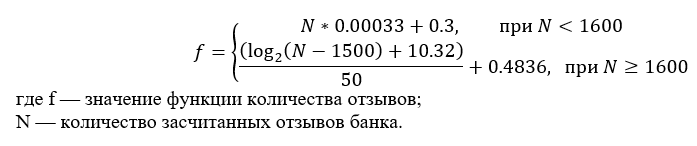

In [22]:
def reviews_function(num_reviews):
    if num_reviews < 1600:
        f = num_reviews * 0.00033 + 0.3
    if num_reviews >= 1600:
        f = ((math.log(num_reviews,2) + 10.32)/50) + 0.4836
    return f

In [23]:
banks_data['reviews_function'] = banks_data['id'].apply(reviews_function)

График значения коэффициента от количества отзывов у банка:

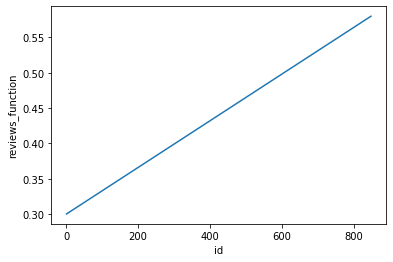

In [24]:
sns.lineplot(x='id',y='reviews_function',data=banks_data);

### Среднее текущее значение рейтинга с учетом фактора времени

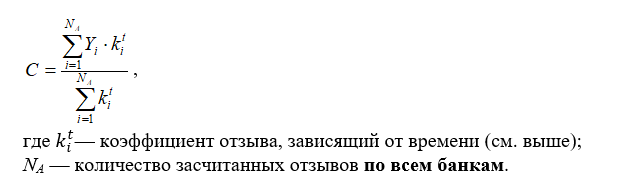

In [25]:
C = banks_data['final_rating'].sum()/banks_data['time_koef'].sum()

## Считаем финальный рейтинг

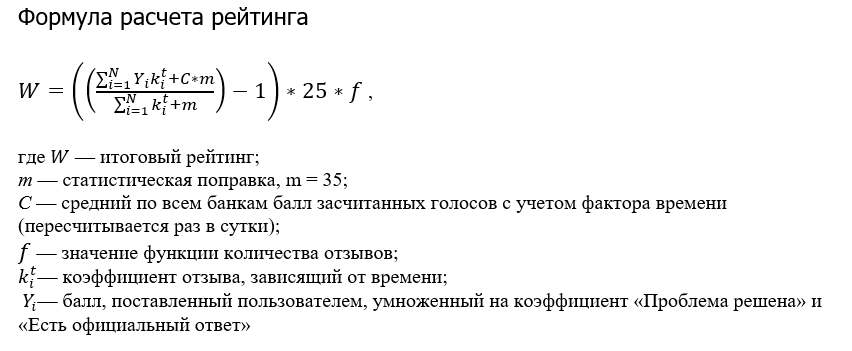

In [26]:
banks_data['final_final'] = ((banks_data['final_rating']+C*35)/(banks_data['time_koef']+35)-1)*35*banks_data['reviews_function']

In [27]:
banks_data.columns = ['final_rating','time_koef','n_reviews','n_solved','n_responses','avg_client_rating','reviews_function','final_final']

In [28]:
banks_data.sort_values('final_final',ascending=False).head(20)

,final_rating,time_koef,n_reviews,n_solved,n_responses,avg_client_rating,reviews_function,final_final
organization_name,,,,,,,,
Совкомбанк,1091.763446,204.442645,448,69.0,444.0,3.379464,0.44784,64.389812
Тинькофф Банк,901.444056,171.719250,420,102.0,408.0,3.511905,0.43860,61.340720
ФК Открытие,1491.828248,321.907441,578,92.0,0.0,3.612457,0.49074,60.935919
Газпромбанк,835.294296,174.641273,305,133.0,272.0,2.986885,0.40065,50.632033
Центр-инвест,437.979526,90.138596,220,2.0,0.0,4.645455,0.37260,46.285021
Сбербанк,645.178269,227.508247,848,25.0,0.0,2.308962,0.57984,39.734806
Уральский Банк реконструкции и развития,134.624604,27.454596,111,8.0,104.0,3.666667,0.33663,38.384596
Банк «Санкт-Петербург»,182.842311,39.601122,95,3.0,20.0,4.010526,0.33135,37.238310
Российский капитал,402.495811,100.693632,183,18.0,5.0,3.830601,0.36039,37.006322
